# The model to predict the salaries of Data Scientists prediction and view the influencing factors 

Summary
The aim of this study is to investigate the factors influencing the salaries of Data Scientists. To achieve this, a dataset containing various relevant variables was utilized. This report describes the exploratory analysis conducted to understand the relationship between these factors and Data Scientists' salaries


## Import libraries

In [50]:
# standard library imports
import pandas as pd
import numpy as np
import sklearn
import os


#visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import fird-party libraries and modules

from angle_emb import AnglE # import emm model for text

import datetime

import country_converter as coco
import wbdata as wb

from dotenv import load_dotenv
load_dotenv()

import json

import requests

import openpyxl

import xgboost as xgb

from sklearn.pipeline import Pipeline as skl_pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PowerTransformer

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings

import optuna

from optuna.visualization.matplotlib import plot_param_importances


import mlflow

client = mlflow.MlflowClient(tracking_uri='http://127.0.0.1:8080')
mlflow.set_tracking_uri='http://127.0.0.1:8080'

import joblib



# output format
pd.set_option('display.float_format', '{:.3f}'.format)
sklearn.set_config(transform_output='pandas')
warnings.filterwarnings("ignore")

# constant
RAND_ST = 345

# path to file
path_to_salary_dataset = 'data/ds_salaries.csv'
path_to_inflation_dataset = 'data/inflation_by_country.xlsx'
path_to_emb_model = 'ext_model/UAE-Large-V1/'


In [2]:
# import xmltodict
json.__version__

'2.0.9'

## Load datasets

In [3]:
df_sal = pd.read_csv(path_to_salary_dataset)
inf_2023 = pd.read_excel(path_to_inflation_dataset)
df_sal.info()
df_sal.head()
inf_2023.info()
inf_2023.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company_locati

company_location  country_name  inflation
0              ARG     Argentina    161.000
1              AUS     Australia      5.400
2              AUT       Austria      5.400
3              BEL       Belgium      0.800
4              BFA  Burkina Faso     -1.600

## Datasets description

### Dataset ds_salary
To conduct this analysis, a dataset containing relevant information about Data Scientists was used. The dataset includes the following variables:

work_year:The year the salary was paid.

experience_level: The experience level in the job during the year.

EN > Entry-level / Junior
MI> Mid-level / Intermediate
SE > Senior-level / Expert
EX > Executive-level / Director

employment_type: The type of employment for the role.

PT > Part-time
FT > Full-time
CT > Contract
FL > Freelance
job_title: The role worked in during the year.

salary: The total gross salary amount paid.

salary_currency: The currency of the salary paid as an ISO 4217 currency code.

salaryinusd: The salary in USD.

employee_residence: Employee's primary country of residence during the work year as an ISO 3166 country code.

remote_ratio:The overall amount of work done remotely.

company_location: The country of the employer's main office or contracting branch.

company_size: The median number of people that worked for the company during the year.  



Data Science Job Salaries Dataset contains 11 columns, each are:

- `work_year`: The year the salary was paid.
- `experience_level`: The experience level in the job during the year
- `employment_type`: The type of employment for the role
- `job_title`: The role worked in during the year.
- `salary`: The total gross salary amount paid.
- `salary_currency`: The currency of the salary paid as an ISO 4217 currency code.
- `salaryinusd`: The salary in USD
- `employee_residence`: Employee's primary country of residence in during the work year as an ISO 3166 country code.
- `remote_ratio`: The overall amount of work done remotely
- `company_location`: The country of the employer's main office or contracting branch
- `company_size`: The median number of people that worked for the company during the year


### Dataset inflation

`inflation_year` - inflation in percents

## EDA

In [4]:
df_sal.describe() #ETL bing api course inflation graph model 

work_year       salary  salary_in_usd  remote_ratio
count   3755.000     3755.000       3755.000      3755.000
mean    2022.374   190695.572     137570.390        46.272
std        0.691   671676.501      63055.625        48.589
min     2020.000     6000.000       5132.000         0.000
25%     2022.000   100000.000      95000.000         0.000
50%     2022.000   138000.000     135000.000         0.000
75%     2023.000   180000.000     175000.000       100.000
max     2023.000 30400000.000     450000.000       100.000

In [5]:
df_sal['job_title'].value_counts()  

job_title
Data Engineer                          1040
Data Scientist                          840
Data Analyst                            612
Machine Learning Engineer               289
Analytics Engineer                      103
                                       ... 
Principal Machine Learning Engineer       1
Azure Data Engineer                       1
Manager Data Management                   1
Marketing Data Engineer                   1
Finance Data Analyst                      1
Name: count, Length: 93, dtype: int64

In [6]:
df_sal['work_year'].value_counts() #+ course + inflation by country + by world  + by us col + https://huggingface.co/WhereIsAI/UAE-Large-V1

work_year
2023    1785
2022    1664
2021     230
2020      76
Name: count, dtype: int64

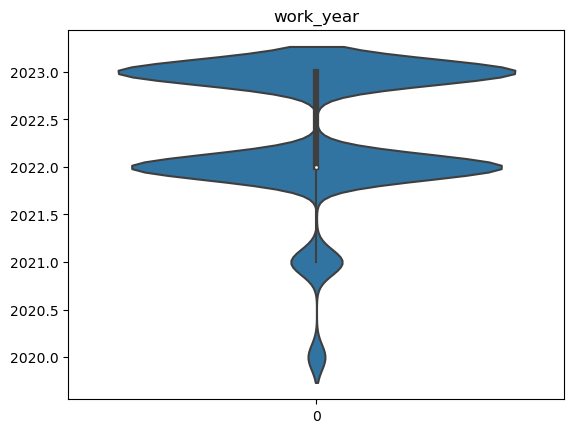

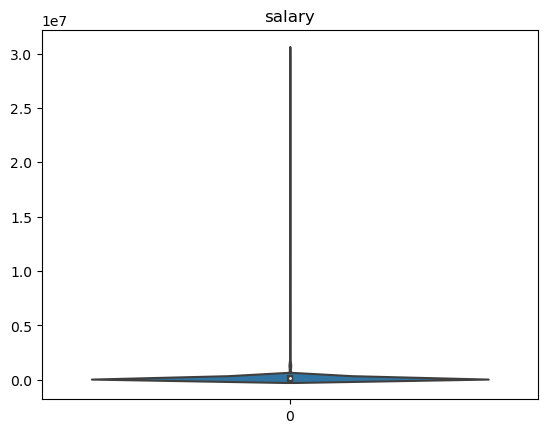

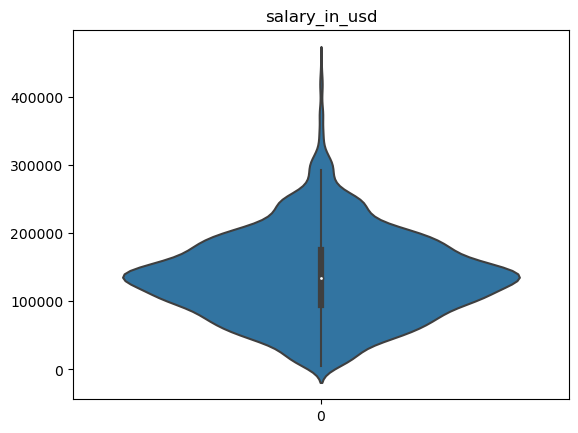

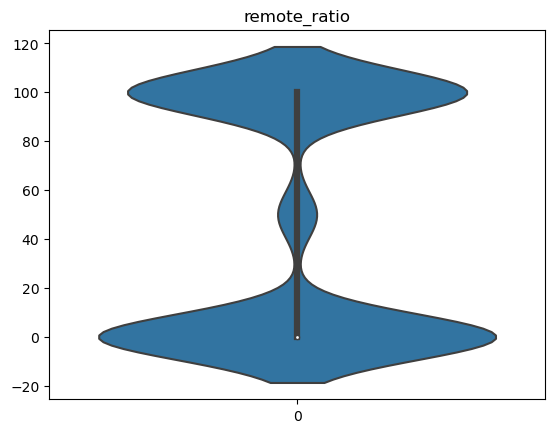

In [7]:
for col in df_sal.select_dtypes(exclude='object').columns:
    sns.violinplot(df_sal[col])
    plt.title(col)
    plt.show()

    # sns.violinplot(df[col])

In [8]:
# Dropping the 'salary' column from the dataframe
df_sal.drop('salary', axis=1, inplace=True)
df_sal.head()

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

  salary_currency  salary_in_usd employee_residence  remote_ratio  \
0             EUR          85847                 ES           100   
1             USD          30000                 US           100   
2             USD          25500                 US           100   
3             USD         175000                 CA           100   
4             USD         120000                 CA           100   

  company_location company_size  
0               ES            L  
1               US            S  
2               US            S  
3               CA            M  
4               CA            M

### Get USD currency exchange rates

In [9]:
currency_list = ', '.join(df_sal['salary_currency'].unique().tolist())
currency_list

'EUR, USD, INR, HKD, CHF, GBP, AUD, SGD, CAD, ILS, BRL, THB, PLN, HUF, CZK, DKK, JPY, MXN, TRY, CLP'

In [10]:
def get_exchange_rates_history(date):
    '''get rates from api'''
    api_url = f'http://api.exchangeratesapi.io/v1/{date}?access_key={os.getenv("API_KEY")}&cbase=EUR&symbols={currency_list}'
    
    try:
        response = requests.get(api_url)
        if response.status_code == 200:
            exchange_rates = pd.Series(response.json()['rates']).to_frame(name='rates').reset_index(names='currency')
            exchange_rates['date'] = int(pd.to_datetime(date).year)
            exchange_rates['usd_rate'] = (
                float(exchange_rates[exchange_rates['currency']=='USD']['rates']) / exchange_rates['rates']
                )
            
            return exchange_rates
    except requests.exceptions.RequestException as error:
        print(f"Error: {error}")
        

In [11]:
exchange_rates_2023 = get_exchange_rates_history('2023-01-01') # for every month you can code a loop
exchange_rates_2022 = get_exchange_rates_history('2022-01-01')
exchange_rates_2021 = get_exchange_rates_history('2021-01-01')
exchange_rates_2020 = get_exchange_rates_history('2020-01-01')

print(exchange_rates_2023, exchange_rates_2022, exchange_rates_2021, exchange_rates_2020)

   currency   rates  date  usd_rate
0       EUR   1.000  2023     1.070
1       USD   1.070  2023     1.000
2       INR  88.580  2023     0.012
3       HKD   8.351  2023     0.128
4       CHF   0.989  2023     1.082
5       GBP   0.885  2023     1.210
6       AUD   1.570  2023     0.682
7       SGD   1.433  2023     0.747
8       CAD   1.449  2023     0.739
9       ILS   3.776  2023     0.283
10      BRL   5.659  2023     0.189
11      THB  37.050  2023     0.029
12      PLN   4.682  2023     0.229
13      HUF 399.671  2023     0.003
14      CZK  24.111  2023     0.044
15      DKK   7.439  2023     0.144
16      JPY 140.143  2023     0.008
17      MXN  20.870  2023     0.051
18      TRY  20.008  2023     0.054
19      CLP 908.011  2023     0.001    currency   rates  date  usd_rate
0       EUR   1.000  2022     1.137
1       USD   1.137  2022     1.000
2       INR  84.733  2022     0.013
3       HKD   8.865  2022     0.128
4       CHF   1.037  2022     1.097
5       GBP   0.840  2022   

In [12]:
exchange_rates_20_23 = pd.concat([exchange_rates_2023, exchange_rates_2022, exchange_rates_2021, exchange_rates_2020], axis=0)
exchange_rates_20_23 = exchange_rates_20_23.reset_index(drop=True)
exchange_rates_20_23

currency   rates  date  usd_rate
0       EUR   1.000  2023     1.070
1       USD   1.070  2023     1.000
2       INR  88.580  2023     0.012
3       HKD   8.351  2023     0.128
4       CHF   0.989  2023     1.082
..      ...     ...   ...       ...
75      DKK   7.471  2020     0.150
76      JPY 121.963  2020     0.009
77      MXN  21.218  2020     0.053
78      TRY   6.672  2020     0.168
79      CLP 830.826  2020     0.001

[80 rows x 4 columns]

In [13]:
exchange_rates_20_23 = exchange_rates_20_23.rename(columns={'currency': 'salary_currency', 'date': 'work_year'})
exchange_rates_20_23.drop('rates', axis=1, inplace=True)
exchange_rates_20_23

salary_currency  work_year  usd_rate
0              EUR       2023     1.070
1              USD       2023     1.000
2              INR       2023     0.012
3              HKD       2023     0.128
4              CHF       2023     1.082
..             ...        ...       ...
75             DKK       2020     0.150
76             JPY       2020     0.009
77             MXN       2020     0.053
78             TRY       2020     0.168
79             CLP       2020     0.001

[80 rows x 3 columns]

In [14]:
# save exchange rates to file
exchange_rates_20_23.to_csv('data/exchange_rates_20_23.csv')

### Get inflation rates


In [15]:
# get list of countries
df_sal['company_location'].value_counts()

company_location
US    3040
GB     172
CA      87
ES      77
IN      58
      ... 
MK       1
BS       1
IR       1
CR       1
MT       1
Name: count, Length: 72, dtype: int64

#### Convert countries from ISO2 to ISO3

In [16]:
# convert countries from ISO2 to ISO3 + country names

# cc = coco.CountryConverter()

df_sal['company_location'] = coco.convert(names=df_sal['company_location'], to='ISO3',not_found=None)
countries = list(df_sal['company_location'].unique())

df_sal['country_name'] = coco.convert(names=df_sal['company_location'], to='name',not_found=None)
df_sal.head()


work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   
3       2023               SE              FT            Data Scientist   
4       2023               SE              FT            Data Scientist   

  salary_currency  salary_in_usd employee_residence  remote_ratio  \
0             EUR          85847                 ES           100   
1             USD          30000                 US           100   
2             USD          25500                 US           100   
3             USD         175000                 CA           100   
4             USD         120000                 CA           100   

  company_location company_size   country_name  
0              ESP            L          Spain  
1              USA            S  United States  
2              USA            S  United States  
3              CAN            M         Canada  
4              CAN            M         Canada

#### Get inflation rates from world bank

You can add cpi index from `wbdata` - World Bank Data

In [17]:
countries = list(df_sal['company_location'].unique())
inf_rates = wb.get_series('FP.CPI.TOTL.ZG', country=countries, column_name='inflation')
inf_rates = pd.DataFrame(inf_rates).reset_index()
inf_rates

country  date  inflation
0      Albania  2022      6.725
1      Albania  2021      2.041
2      Albania  2020      1.621
3      Albania  2019      1.411
4      Albania  2018      2.028
...        ...   ...        ...
4531  Viet Nam  1964        NaN
4532  Viet Nam  1963        NaN
4533  Viet Nam  1962        NaN
4534  Viet Nam  1961        NaN
4535  Viet Nam  1960        NaN

[4536 rows x 3 columns]

In [18]:
inf_rates.columns = ['country_name', 'work_year', 'inflation']
inf_rates

country_name work_year  inflation
0         Albania      2022      6.725
1         Albania      2021      2.041
2         Albania      2020      1.621
3         Albania      2019      1.411
4         Albania      2018      2.028
...           ...       ...        ...
4531     Viet Nam      1964        NaN
4532     Viet Nam      1963        NaN
4533     Viet Nam      1962        NaN
4534     Viet Nam      1961        NaN
4535     Viet Nam      1960        NaN

[4536 rows x 3 columns]

In [19]:
inf_rates.dtypes

country_name     object
work_year        object
inflation       float64
dtype: object

In [20]:
inf_rates['work_year'] = inf_rates['work_year'].astype('int')
inf_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4536 entries, 0 to 4535
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_name  4536 non-null   object 
 1   work_year     4536 non-null   int64  
 2   inflation     3607 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 106.4+ KB


In [21]:
inf_rates['work_year'].value_counts()

work_year
2022    72
1975    72
1988    72
1987    72
1986    72
        ..
1996    72
1995    72
1994    72
1993    72
1960    72
Name: count, Length: 63, dtype: int64

In [22]:
temp_inf = inf_rates.copy()

In [23]:
inf_rates = inf_rates.drop(inf_rates[inf_rates['work_year']<2020].index, axis=0)
inf_rates

country_name  work_year  inflation
0                  Albania       2022      6.725
1                  Albania       2021      2.041
2                  Albania       2020      1.621
63    United Arab Emirates       2022      4.828
64    United Arab Emirates       2021     -0.014
...                    ...        ...        ...
4411         United States       2021      4.698
4412         United States       2020      1.234
4473              Viet Nam       2022      3.157
4474              Viet Nam       2021      1.835
4475              Viet Nam       2020      3.221

[216 rows x 3 columns]

In [24]:
inf_rates.isna().sum()

country_name     0
work_year        0
inflation       13
dtype: int64

In [25]:
temp_inf = inf_rates.copy()

In [26]:
# get same country_name for all dfs
inf_rates['company_location'] = coco.convert(names=inf_rates['country_name'], to='ISO3', not_found=None)

inf_rates['country_name'] = coco.convert(names=inf_rates['company_location'], to='name', not_found=None)
inf_rates


country_name  work_year  inflation company_location
0                  Albania       2022      6.725              ALB
1                  Albania       2021      2.041              ALB
2                  Albania       2020      1.621              ALB
63    United Arab Emirates       2022      4.828              ARE
64    United Arab Emirates       2021     -0.014              ARE
...                    ...        ...        ...              ...
4411         United States       2021      4.698              USA
4412         United States       2020      1.234              USA
4473               Vietnam       2022      3.157              VNM
4474               Vietnam       2021      1.835              VNM
4475               Vietnam       2020      3.221              VNM

[216 rows x 4 columns]

In [27]:
# Filter rows where 'inflation' is NaN
inf_rates[inf_rates['inflation'].isna()]

country_name  work_year  inflation company_location
126                Argentina       2022        NaN              ARG
127                Argentina       2021        NaN              ARG
128                Argentina       2020        NaN              ARG
252           American Samoa       2022        NaN              ASM
253           American Samoa       2021        NaN              ASM
254           American Samoa       2020        NaN              ASM
567   Bosnia and Herzegovina       2022        NaN              BIH
568   Bosnia and Herzegovina       2021        NaN              BIH
569   Bosnia and Herzegovina       2020        NaN              BIH
3717             Puerto Rico       2022        NaN              PRI
3718             Puerto Rico       2021        NaN              PRI
3719             Puerto Rico       2020        NaN              PRI
3906                  Russia       2022        NaN              RUS

In [28]:
# Filter out rows with missing inflation rates
inf_nan = inf_rates[inf_rates['inflation'].isna()].copy()
inf_nan

country_name  work_year  inflation company_location
126                Argentina       2022        NaN              ARG
127                Argentina       2021        NaN              ARG
128                Argentina       2020        NaN              ARG
252           American Samoa       2022        NaN              ASM
253           American Samoa       2021        NaN              ASM
254           American Samoa       2020        NaN              ASM
567   Bosnia and Herzegovina       2022        NaN              BIH
568   Bosnia and Herzegovina       2021        NaN              BIH
569   Bosnia and Herzegovina       2020        NaN              BIH
3717             Puerto Rico       2022        NaN              PRI
3718             Puerto Rico       2021        NaN              PRI
3719             Puerto Rico       2020        NaN              PRI
3906                  Russia       2022        NaN              RUS

In [29]:
# imput inflation by country
inf_nan['inflation'] = [94.80, 48.41, 42.02, 2.20, 2.00, 1.80, 3.90, 1.30, 1.10, 2.10, 1.20, 0.60, 8.60]
inf_nan

country_name  work_year  inflation company_location
126                Argentina       2022     94.800              ARG
127                Argentina       2021     48.410              ARG
128                Argentina       2020     42.020              ARG
252           American Samoa       2022      2.200              ASM
253           American Samoa       2021      2.000              ASM
254           American Samoa       2020      1.800              ASM
567   Bosnia and Herzegovina       2022      3.900              BIH
568   Bosnia and Herzegovina       2021      1.300              BIH
569   Bosnia and Herzegovina       2020      1.100              BIH
3717             Puerto Rico       2022      2.100              PRI
3718             Puerto Rico       2021      1.200              PRI
3719             Puerto Rico       2020      0.600              PRI
3906                  Russia       2022      8.600              RUS

In [30]:
inf_rates['inflation'].fillna(inf_nan['inflation'], inplace=True)


In [31]:
# check if there are still NaN values
inf_rates.query('country_name == "Argentina"')

country_name  work_year  inflation company_location
126    Argentina       2022     94.800              ARG
127    Argentina       2021     48.410              ARG
128    Argentina       2020     42.020              ARG

#### Preprocessor 2023 year inflation rates

In [32]:
# inf_2023.rename(columns={'country_code': 'company_location'}, inplace=True)
inf_2023

company_location  country_name  inflation
0                ARG     Argentina    161.000
1                AUS     Australia      5.400
2                AUT       Austria      5.400
3                BEL       Belgium      0.800
4                BFA  Burkina Faso     -1.600
..               ...           ...        ...
100              IRQ          Iraq      3.980
101              CHN         China     -0.500
102              MDA       Moldova      5.500
103              POL        Poland      6.100
104              MLT         Malta      3.900

[105 rows x 3 columns]

In [33]:
inf_2023['work_year'] = 2023
inf_2023


company_location  country_name  inflation  work_year
0                ARG     Argentina    161.000       2023
1                AUS     Australia      5.400       2023
2                AUT       Austria      5.400       2023
3                BEL       Belgium      0.800       2023
4                BFA  Burkina Faso     -1.600       2023
..               ...           ...        ...        ...
100              IRQ          Iraq      3.980       2023
101              CHN         China     -0.500       2023
102              MDA       Moldova      5.500       2023
103              POL        Poland      6.100       2023
104              MLT         Malta      3.900       2023

[105 rows x 4 columns]

### Merge dataframes

In [34]:
temp_df = inf_rates.copy()

In [35]:
inf_rates.reset_index(drop=True, inplace=True)
inf_rates

country_name  work_year  inflation company_location
0                 Albania       2022      6.725              ALB
1                 Albania       2021      2.041              ALB
2                 Albania       2020      1.621              ALB
3    United Arab Emirates       2022      4.828              ARE
4    United Arab Emirates       2021     -0.014              ARE
..                    ...        ...        ...              ...
211         United States       2021      4.698              USA
212         United States       2020      1.234              USA
213               Vietnam       2022      3.157              VNM
214               Vietnam       2021      1.835              VNM
215               Vietnam       2020      3.221              VNM

[216 rows x 4 columns]

In [36]:
inf_2023

company_location  country_name  inflation  work_year
0                ARG     Argentina    161.000       2023
1                AUS     Australia      5.400       2023
2                AUT       Austria      5.400       2023
3                BEL       Belgium      0.800       2023
4                BFA  Burkina Faso     -1.600       2023
..               ...           ...        ...        ...
100              IRQ          Iraq      3.980       2023
101              CHN         China     -0.500       2023
102              MDA       Moldova      5.500       2023
103              POL        Poland      6.100       2023
104              MLT         Malta      3.900       2023

[105 rows x 4 columns]

In [37]:
inf_rates_all = pd.concat([inf_rates, inf_2023], ignore_index=True)
inf_rates_all

country_name  work_year  inflation company_location
0                 Albania       2022      6.725              ALB
1                 Albania       2021      2.041              ALB
2                 Albania       2020      1.621              ALB
3    United Arab Emirates       2022      4.828              ARE
4    United Arab Emirates       2021     -0.014              ARE
..                    ...        ...        ...              ...
316                  Iraq       2023      3.980              IRQ
317                 China       2023     -0.500              CHN
318               Moldova       2023      5.500              MDA
319                Poland       2023      6.100              POL
320                 Malta       2023      3.900              MLT

[321 rows x 4 columns]

In [38]:
temp = pd.concat([inf_rates, inf_2023], ignore_index=True)
temp

country_name  work_year  inflation company_location
0                 Albania       2022      6.725              ALB
1                 Albania       2021      2.041              ALB
2                 Albania       2020      1.621              ALB
3    United Arab Emirates       2022      4.828              ARE
4    United Arab Emirates       2021     -0.014              ARE
..                    ...        ...        ...              ...
316                  Iraq       2023      3.980              IRQ
317                 China       2023     -0.500              CHN
318               Moldova       2023      5.500              MDA
319                Poland       2023      6.100              POL
320                 Malta       2023      3.900              MLT

[321 rows x 4 columns]

In [39]:
# suffixes=('', '_inf') for example
df_sal.merge(temp, how='left', on=['company_location', 'work_year'], suffixes=('', '_inf'))

work_year experience_level employment_type                 job_title  \
0          2023               SE              FT  Principal Data Scientist   
1          2023               MI              CT               ML Engineer   
2          2023               MI              CT               ML Engineer   
3          2023               SE              FT            Data Scientist   
4          2023               SE              FT            Data Scientist   
...         ...              ...             ...                       ...   
3750       2020               SE              FT            Data Scientist   
3751       2021               MI              FT  Principal Data Scientist   
3752       2020               EN              FT            Data Scientist   
3753       2020               EN              CT     Business Data Analyst   
3754       2021               SE              FT      Data Science Manager   

     salary_currency  salary_in_usd employee_residence  remote_ratio  \
0                EUR          85847                 ES           100   
1                USD          30000                 US           100   
2                USD          25500                 US           100   
3                USD         175000                 CA           100   
4                USD         120000                 CA           100   
...              ...            ...                ...           ...   
3750             USD         412000                 US           100   
3751             USD         151000                 US           100   
3752             USD         105000                 US           100   
3753             USD         100000                 US           100   
3754             INR          94665                 IN            50   

     company_location company_size   country_name country_name_inf  inflation  
0                 ESP            L          Spain            Spain      3.200  
1                 USA            S  United States    United States      3.100  
2                 USA            S  United States    United States      3.100  
3                 CAN            M         Canada           Canada      3.100  
4                 CAN            M         Canada           Canada      3.100  
...               ...          ...            ...              ...        ...  
3750              USA            L  United States    United States      1.234  
3751              USA            L  United States    United States      4.698  
3752              USA            S  United States    United States      1.234  
3753              USA            L  United States    United States      1.234  
3754              IND            L          India            India      5.131  

[3755 rows x 13 columns]

In [40]:
inf_rates_all.to_csv('data/inflation_rates.csv')

In [41]:
inf_rates_all.drop('country_name', axis=1, inplace=True)
inf_rates_all

work_year  inflation company_location
0         2022      6.725              ALB
1         2021      2.041              ALB
2         2020      1.621              ALB
3         2022      4.828              ARE
4         2021     -0.014              ARE
..         ...        ...              ...
316       2023      3.980              IRQ
317       2023     -0.500              CHN
318       2023      5.500              MDA
319       2023      6.100              POL
320       2023      3.900              MLT

[321 rows x 3 columns]

In [42]:
# merge inflation rates with df_sal, merge only rows in df_sal
df_temp = df_sal.merge(inf_rates_all, how='left', on=['company_location', 'work_year'])

# Print the number of NaN values in the 'inflation' column of df_temp
print(f'df_temp nan = {df_temp["inflation"].isna().sum()}')

print(f'df_sal.shape={df_sal.shape}, df_temp.shape={df_temp.shape}')



df_temp nan = 0
df_sal.shape=(3755, 11), df_temp.shape=(3755, 12)


In [43]:
df_temp.merge(exchange_rates_20_23, how='left', on=['salary_currency', 'work_year'])

work_year experience_level employment_type                 job_title  \
0          2023               SE              FT  Principal Data Scientist   
1          2023               MI              CT               ML Engineer   
2          2023               MI              CT               ML Engineer   
3          2023               SE              FT            Data Scientist   
4          2023               SE              FT            Data Scientist   
...         ...              ...             ...                       ...   
3750       2020               SE              FT            Data Scientist   
3751       2021               MI              FT  Principal Data Scientist   
3752       2020               EN              FT            Data Scientist   
3753       2020               EN              CT     Business Data Analyst   
3754       2021               SE              FT      Data Science Manager   

     salary_currency  salary_in_usd employee_residence  remote_ratio  \
0                EUR          85847                 ES           100   
1                USD          30000                 US           100   
2                USD          25500                 US           100   
3                USD         175000                 CA           100   
4                USD         120000                 CA           100   
...              ...            ...                ...           ...   
3750             USD         412000                 US           100   
3751             USD         151000                 US           100   
3752             USD         105000                 US           100   
3753             USD         100000                 US           100   
3754             INR          94665                 IN            50   

     company_location company_size   country_name  inflation  usd_rate  
0                 ESP            L          Spain      3.200     1.070  
1                 USA            S  United States      3.100     1.000  
2                 USA            S  United States      3.100     1.000  
3                 CAN            M         Canada      3.100     1.000  
4                 CAN            M         Canada      3.100     1.000  
...               ...          ...            ...        ...       ...  
3750              USA            L  United States      1.234     1.000  
3751              USA            L  United States      4.698     1.000  
3752              USA            S  United States      1.234     1.000  
3753              USA            L  United States      1.234     1.000  
3754              IND            L          India      5.131     0.014  

[3755 rows x 13 columns]

In [44]:
df_temp = df_temp.merge(exchange_rates_20_23, how='left', on=['salary_currency', 'work_year'])
print(df_temp.isna().sum())
df_temp


work_year             0
experience_level      0
employment_type       0
job_title             0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
country_name          0
inflation             0
usd_rate              0
dtype: int64


work_year experience_level employment_type                 job_title  \
0          2023               SE              FT  Principal Data Scientist   
1          2023               MI              CT               ML Engineer   
2          2023               MI              CT               ML Engineer   
3          2023               SE              FT            Data Scientist   
4          2023               SE              FT            Data Scientist   
...         ...              ...             ...                       ...   
3750       2020               SE              FT            Data Scientist   
3751       2021               MI              FT  Principal Data Scientist   
3752       2020               EN              FT            Data Scientist   
3753       2020               EN              CT     Business Data Analyst   
3754       2021               SE              FT      Data Science Manager   

     salary_currency  salary_in_usd employee_residence  remote_ratio  \
0                EUR          85847                 ES           100   
1                USD          30000                 US           100   
2                USD          25500                 US           100   
3                USD         175000                 CA           100   
4                USD         120000                 CA           100   
...              ...            ...                ...           ...   
3750             USD         412000                 US           100   
3751             USD         151000                 US           100   
3752             USD         105000                 US           100   
3753             USD         100000                 US           100   
3754             INR          94665                 IN            50   

     company_location company_size   country_name  inflation  usd_rate  
0                 ESP            L          Spain      3.200     1.070  
1                 USA            S  United States      3.100     1.000  
2                 USA            S  United States      3.100     1.000  
3                 CAN            M         Canada      3.100     1.000  
4                 CAN            M         Canada      3.100     1.000  
...               ...          ...            ...        ...       ...  
3750              USA            L  United States      1.234     1.000  
3751              USA            L  United States      4.698     1.000  
3752              USA            S  United States      1.234     1.000  
3753              USA            L  United States      1.234     1.000  
3754              IND            L          India      5.131     0.014  

[3755 rows x 13 columns]

In [45]:
df_temp.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
country_name          0
inflation             0
usd_rate              0
dtype: int64

## Use embedded model

In [51]:
angle = AnglE.from_pretrained(path_to_emb_model, pooling_strategy='cls').cuda()
vec = angle.encode(df_temp['job_title'].unique().tolist(), to_numpy=True)
vec
# cosine similarity sklearn  claster + loop or apply  + crossjoin + chatgpt 

array([[-0.04124779, -0.33970574, -0.08115742, ..., -0.32802904,
        -0.6645141 ,  0.44380358],
       [ 0.36518157, -0.19456291, -0.6203074 , ...,  0.03742797,
         0.05976051,  0.25870818],
       [ 0.10503013, -0.17102742, -0.24323422, ..., -0.5096958 ,
        -0.61439955,  0.62031615],
       ...,
       [-0.43986318, -0.30163333, -0.5311187 , ..., -0.30088165,
        -0.14300254,  0.00543072],
       [-0.20688699, -0.4244208 , -0.3101868 , ..., -0.22334342,
        -0.38304207,  0.5325698 ],
       [-0.349876  ,  0.11804834, -0.10622168, ..., -0.10038464,
        -0.32796028,  0.41569325]], dtype=float32)

In [49]:
df_sal_to_model = df_temp.copy()

In [50]:
#drop unnecessary cols
df_sal_to_model.drop(columns=['work_year', 'country_name'], axis=1, inplace=True)
df_sal_to_model.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   experience_level    3755 non-null   object 
 1   employment_type     3755 non-null   object 
 2   job_title           3755 non-null   object 
 3   salary_currency     3755 non-null   object 
 4   salary_in_usd       3755 non-null   int64  
 5   employee_residence  3755 non-null   object 
 6   remote_ratio        3755 non-null   int64  
 7   company_location    3755 non-null   object 
 8   company_size        3755 non-null   object 
 9   inflation           3755 non-null   float64
 10  usd_rate            3755 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 322.8+ KB


### Boxplot for new df

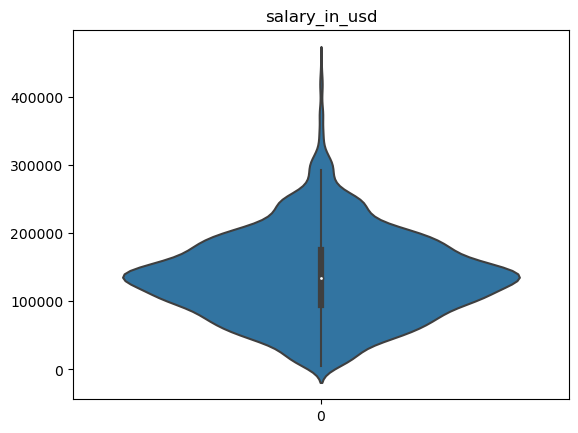

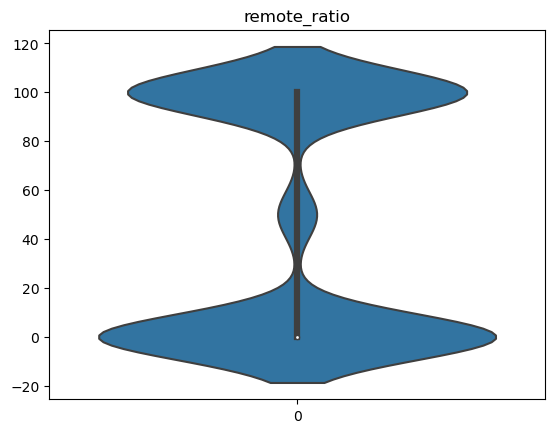

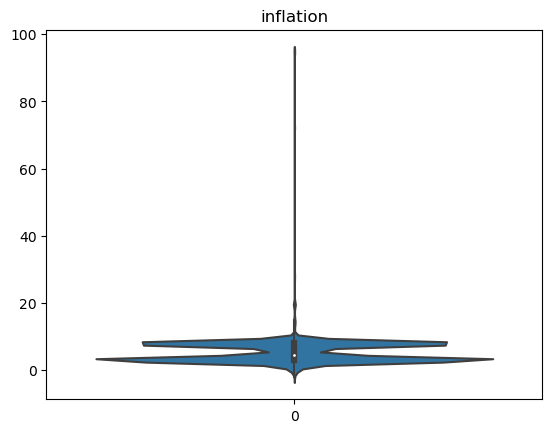

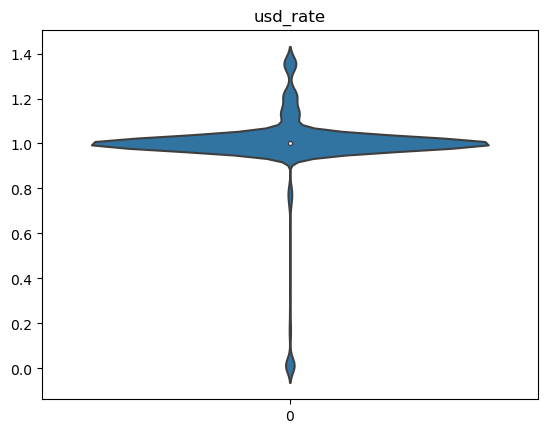

In [51]:
for col in df_sal_to_model.select_dtypes(exclude='object').columns:
    sns.violinplot(df_sal_to_model[col])
    plt.title(col)
    plt.show()

## Df split to train and test

In [52]:
X, y = df_sal_to_model.drop('salary_in_usd', axis=1), df_sal_to_model['salary_in_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=RAND_ST)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2816, 10) (939, 10) (2816,) (939,)


## Make pipeline

In [68]:
num_cols = X_train.select_dtypes(exclude='object').columns
cat_cols = X_train.select_dtypes(include='object').columns

num_transformer = skl_pipeline(steps=[
    #num_transform
    ('power',
     PowerTransformer()
    )
    ])

cat_transformer_ohe = skl_pipeline(steps=[
    ('ohe',
     OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)) # drop = 'if_binary' if cat will not change + ordinalecn
    ])

cat_transformer_oe = skl_pipeline(steps=[
    ('oe',
     OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)) # drop = 'if_binary' if cat will not change
    ])


# make preprocessor
preprocessor = ColumnTransformer(
    remainder='passthrough',
    transformers=[
        ('num_transformer', num_transformer, num_cols),
        ('cat_transformer_oe', cat_transformer_oe, cat_cols)
        ]
    )

# make pipe model

pipe_xgbr = skl_pipeline(steps=[
    ('preprocessor', preprocessor),

    ('model_xgbr', xgb.XGBRegressor(random_state=RAND_ST)) # +cat cols in xgb 2-nd model
])

pipe_xgbr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  Index(['remote_ratio', 'inflation', 'usd_rate'], dtype='object')),
                                                 ('cat_transformer_oe',
                                                  Pipeline(steps=[('oe',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['experience...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=345, ...))])

In [69]:
# preprocessor check
preprocessor.fit(X_train, y_train)
preprocessor.transform(X_test)

num_transformer__remote_ratio  num_transformer__inflation  \
2754                         -0.974                       0.940   
1898                         -0.974                       0.940   
3415                          1.051                       0.940   
62                            1.051                      -0.783   
728                          -0.974                      -0.783   
...                             ...                         ...   
163                          -0.974                      -0.783   
3566                          0.773                      -0.800   
583                          -0.974                      -0.125   
2229                         -0.974                       0.940   
3033                          1.051                       7.605   

      num_transformer__usd_rate  cat_transformer_oe__experience_level  \
2754                     -0.135                                 3.000   
1898                     -0.135                                 2.000   
3415                     -0.135                                 3.000   
62                       -0.135                                 3.000   
728                      -0.135                                 2.000   
...                         ...                                   ...   
163                      -0.135                                 3.000   
3566                      2.095                                 3.000   
583                       2.003                                 2.000   
2229                     -0.135                                 3.000   
3033                     -0.135                                 0.000   

      cat_transformer_oe__employment_type  cat_transformer_oe__job_title  \
2754                                2.000                         23.000   
1898                                2.000                         30.000   
3415                                2.000                         43.000   
62                                  2.000                         43.000   
728                                 2.000                         62.000   
...                                   ...                            ...   
163                                 2.000                          8.000   
3566                                2.000                         65.000   
583                                 2.000                         43.000   
2229                                2.000                         43.000   
3033                                2.000                         23.000   

      cat_transformer_oe__salary_currency  \
2754                               19.000   
1898                               19.000   
3415                               19.000   
62                                 19.000   
728                                19.000   
...                                   ...   
163                                19.000   
3566                                7.000   
583                                 8.000   
2229                               19.000   
3033                               19.000   

      cat_transformer_oe__employee_residence  \
2754                                  69.000   
1898                                  69.000   
3415                                  69.000   
62                                    69.000   
728                                   69.000   
...                                      ...   
163                                   69.000   
3566                                  20.000   
583                                   28.000   
2229                                  69.000   
3033                                   2.000   

      cat_transformer_oe__company_location  cat_transformer_oe__company_size  
2754                                65.000                             1.000  
1898                                65.000                             1.000  
3415                                65.000              

## Hyperparameters optimize

In [70]:
def hyper_opt(trial):
    '''add hyperparameters from xgb model'''
    num_cols = X_train.select_dtypes(exclude='object').columns
    cat_cols = X_train.select_dtypes(include='object').columns

    hyperparameters = {
        'model_xgbr__learning_rate': trial.suggest_float('model_xgbr__learning_rate', 0.06, 0.1), # alias for eta
        'model_xgbr__min_split_loss': trial.suggest_int('model_xgbr__min_split_loss', 0, 150000),    # alias for gamma
        'model_xgbr__max_depth': trial.suggest_int('model_xgbr__max_depth', 1, 100),
        'model_xgbr__min_child_weight': trial.suggest_int('model_xgbr__min_child_weight', 1, 20),
        'model_xgbr__subsample': trial.suggest_float('model_xgbr__subsample', 0.5, 1),
        'model_xgbr__colsample_bytree': trial.suggest_float('model_xgbr__colsample_bytree', 0.5, 1),
        'model_xgbr__reg_lambda': trial.suggest_int('model_xgbr__reg_lambda', 0, 200),
        'model_xgbr__reg_alpha': trial.suggest_int('model_xgbr__reg_alpha', 0, 100),    #???
        'model_xgbr__n_estimators': 100,
        'model_xgbr__max_leaves': trial.suggest_int('model_xgbr__max_leaves', 2, 100),
        'model_xgbr__categorical_feature': list(cat_cols)  # Specify categorical features
    }



    num_transformer = skl_pipeline(steps=[
        #num_transform
        ('power',
        PowerTransformer()
        )
        ])

    cat_transformer_ohe = skl_pipeline(steps=[
        ('ohe',
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)) # drop = 'if_binary' if cat will not change
        ])

    cat_transformer_oe = skl_pipeline(steps=[
    ('oe',
     OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)) # drop = 'if_binary' if cat will not change
    ])

    
    # make preprocessor
    preprocessor = ColumnTransformer(
        remainder='passthrough',
        transformers=[
            ('num_transformer', num_transformer, num_cols),
            ('cat_transformer_oe', cat_transformer_oe, cat_cols)
            ]
        )

    # make pipe model

    pipe_xgbr = skl_pipeline(steps=[
        ('preprocessor', preprocessor),

        ('model_xgbr', xgb.XGBRegressor(random_state=RAND_ST))
    ])

    pipe_xgbr.set_params(**hyperparameters) #разименование
    
    return cross_val_score(pipe_xgbr, X_train, y_train, scoring='neg_mean_squared_error').mean()

### Optuna apply

In [71]:
try:
    study = optuna.create_study(direction='maximize')
    study.optimize(hyper_opt, n_trials=100)
except KeyboardInterrupt:
    print("Optimization interrupted by user.")


[I 2024-01-12 08:57:49,810] A new study created in memory with name: no-name-dc839e6b-b173-4eac-8d20-80bdb43cb343
[I 2024-01-12 08:57:50,656] Trial 0 finished with value: -2237197027.6864123 and parameters: {'model_xgbr__learning_rate': 0.09726165768924569, 'model_xgbr__min_split_loss': 115556, 'model_xgbr__max_depth': 52, 'model_xgbr__min_child_weight': 1, 'model_xgbr__subsample': 0.6156249930467534, 'model_xgbr__colsample_bytree': 0.5395430272492064, 'model_xgbr__reg_lambda': 67, 'model_xgbr__reg_alpha': 77, 'model_xgbr__max_leaves': 71}. Best is trial 0 with value: -2237197027.6864123.
[I 2024-01-12 08:57:51,203] Trial 1 finished with value: -2275599120.090483 and parameters: {'model_xgbr__learning_rate': 0.08560493398932963, 'model_xgbr__min_split_loss': 102291, 'model_xgbr__max_depth': 54, 'model_xgbr__min_child_weight': 16, 'model_xgbr__subsample': 0.505899453409149, 'model_xgbr__colsample_bytree': 0.5181145477522534, 'model_xgbr__reg_lambda': 28, 'model_xgbr__reg_alpha': 86, 'mo

{'model_xgbr__learning_rate': 0.06742862533789133, 'model_xgbr__min_split_loss': 28654, 'model_xgbr__max_depth': 43, 'model_xgbr__min_child_weight': 9, 'model_xgbr__subsample': 0.9155260501917724, 'model_xgbr__colsample_bytree': 0.7609985665597031, 'model_xgbr__reg_lambda': 20, 'model_xgbr__reg_alpha': 85, 'model_xgbr__max_leaves': 50}


-2207084848.4233913

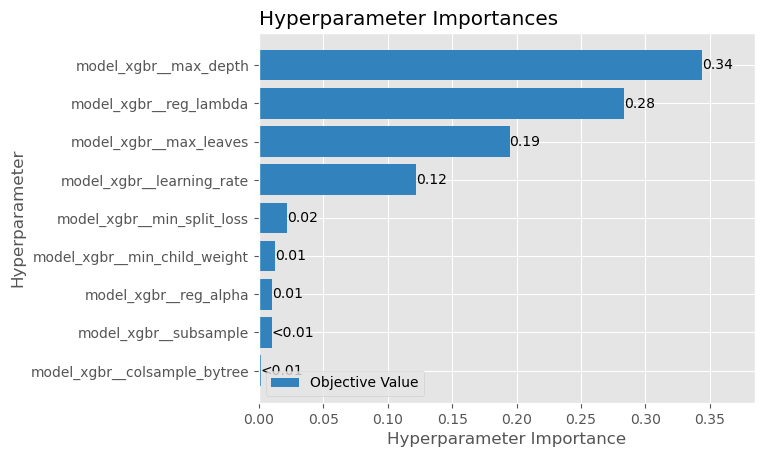

In [72]:
print(study.best_params)

plot_param_importances(study);
study.best_value

## Model save in mlflow

In [61]:
mlflow.set_experiment('salary_prediction')

<Experiment: artifact_location='file:///home/pmu/zet/obs-h/Projects_od/ds_salary/mlruns/883913715377222921', creation_time=1704644289517, experiment_id='883913715377222921', last_update_time=1704644289517, lifecycle_stage='active', name='salary_prediction', tags={}>

### Hyperpams and feature impotences

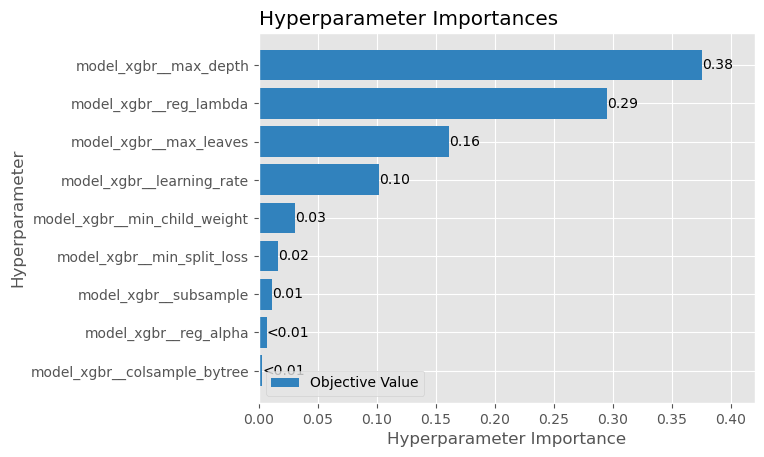

In [74]:
hyperpams = optuna.visualization.matplotlib.plot_param_importances(study)
plt.savefig('hyperpams_oe.png')

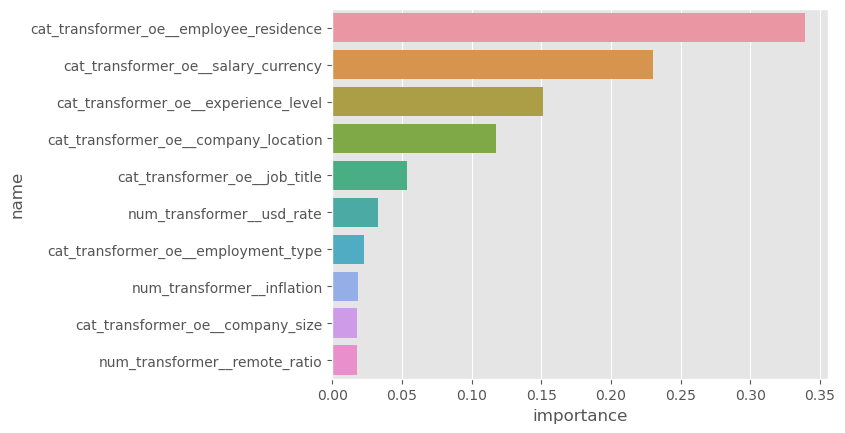

In [75]:
# Importing the required data into a Pandas DataFrame
importance = pd.DataFrame({
    'name': pipe_xgbr['preprocessor'].get_feature_names_out(), # Get names of the features used in the model
    'importance': pipe_xgbr['model_xgbr'].feature_importances_ # Get the importance of each feature
})

# Sorting the data based on the importance of each feature
importance.sort_values('importance', ascending=False, inplace=True)
importance.head(10)

# Plotting a barplot of the feature importances using seaborn
sns.barplot(data=importance.head(15), y='name', x='importance')
plt.savefig('features_imp_oe.png')

In [140]:

    
# Fit the XGBoost model with the best hyperparameters
pipe_xgbr.set_params(**study.best_params)
pipe_xgbr.fit(X_train, y_train)
predict_test = pipe_xgbr.predict(X_test)


print(f'''
    'mae='{mean_absolute_error(y_test, predict_test)},
    'n_mse='{study.best_value / len(y_train) * 0.8},
    'median_abs_error='{abs(y_test - predict_test).median()},
    'mean_relative_error=' {(abs(y_test - predict_test) / y_test).mean()},
    'median_relative_error='{(abs(y_test - predict_test) / y_test).median()}
    ''')



    'mae='36131.61181796625,
    'n_mse='-627012.7410293726,
    'median_abs_error='27902.296875,
    'mean_relative_error=' 0.35949735960211177,
    'median_relative_error='0.22203028846153847
    


In [143]:
predict_test

array([124572.74 , 131537.11 , 158609.08 , 174634.22 , 154610.95 ,
       137858.84 ,  63377.785, 184094.27 , 180905.42 , 138015.77 ,
       109320.76 , 115661.266,  54388.824, 180905.42 , 124572.74 ,
       124572.74 , 172798.5  ,  42761.97 , 159650.4  , 174079.58 ,
       100425.54 , 120579.305,  69899.38 , 154573.11 , 171910.7  ,
       174634.22 , 174634.22 ,  53475.598,  76581.22 , 171910.7  ,
       129746.125,  78270.36 , 169865.67 , 171244.33 , 109395.26 ,
       162645.75 , 115419.28 , 130932.46 , 105385.78 , 104458.51 ,
       162492.48 , 152073.36 , 171910.7  ,  47273.55 ,  54388.824,
       186838.73 , 131212.11 , 109843.6  , 177279.83 , 180905.42 ,
       214487.69 , 124572.74 , 174634.22 , 159650.4  , 156218.47 ,
       174634.22 , 179122.81 , 103132.13 , 150699.97 ,  78721.234,
       102597.43 ,  77519.56 , 181644.9  , 159112.1  , 108319.516,
       179122.81 , 186838.73 , 121356.3  ,  24007.123, 126787.33 ,
       159650.4  , 181980.06 , 150699.97 , 159112.1  , 150699.

In [144]:
with mlflow.start_run(run_name='tmp_model_oe'):
    # Log the hyperparameters
    mlflow.log_params(study.best_params)
    
    # Fit the XGBoost model with the best hyperparameters
    pipe_xgbr.set_params(**study.best_params)
    pipe_xgbr.fit(X_train, y_train)
    predict_test = pipe_xgbr.predict(X_test)
    metrics = {
        'mae': mean_absolute_error(y_test, predict_test),
        # 'n_mse': study.best_value / len(y_train) * 0.8, # if cv = 5 # it is not 
        'mse': mean_squared_error(y_test, predict_test),
        'median_abs_error': abs(y_test - predict_test).median(),
        'mean_relative_error': (abs(y_test - predict_test) / y_test).mean(),
        'median_relative_error': (abs(y_test - predict_test) / y_test).median()
    } 
    
    mlflow.log_artifact('hyperpams_oe.png') 
    mlflow.log_artifact('features_imp_oe.png') 
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(pipe_xgbr, 'tmp_model_oe')

## Models comparison

In [65]:
# Set path to logged models
logged_model_ohe = 'runs:/ae0aa94b4a0f446baa72da78f1dd9866/tmp_model_ohe'

# Load the logged models
loaded_model_ohe = mlflow.sklearn.load_model(logged_model_ohe)

### OHE model

In [66]:
# tmp model ohe save
# joblib.dump(loaded_model_ohe, 'tmp_model_ohe.joblib')

['tmp_model_ohe.joblib']

In [53]:
# check saved model
tmp_model_ohe = joblib.load('tmp_model_ohe.joblib')
y_pred_loc_ohe = tmp_model_ohe.predict(X_test)
y_pred_loc_ohe


array([121927.54 , 127714.36 , 158829.83 , 173973.84 , 159313.36 ,
       153466.4  ,  70080.375, 178482.89 , 186850.3  , 139323.17 ,
        95565.12 , 113215.38 ,  66463.08 , 186850.3  , 121927.54 ,
       121927.54 , 174241.28 ,  45892.11 , 160321.92 , 173299.61 ,
        98802.305, 119112.23 ,  68195.805, 153231.22 , 170490.39 ,
       173973.84 , 173973.84 ,  40513.297,  76164.78 , 170490.39 ,
       127614.99 ,  50472.54 , 169316.55 , 162851.14 , 116145.06 ,
       158663.73 , 125949.66 , 142802.84 , 106652.28 , 122265.59 ,
       161141.7  , 151279.7  , 170490.39 ,  54186.188,  66463.08 ,
       189191.7  , 134288.38 , 145745.58 , 182574.75 , 186850.3  ,
       206658.97 , 121927.54 , 173973.84 , 160321.92 , 157774.17 ,
       173973.84 , 179023.6  , 133690.72 , 149272.14 ,  82313.26 ,
       128199.33 ,  82575.28 , 176256.34 , 159999.77 , 152055.31 ,
       179023.6  , 189191.7  , 120519.15 ,  23402.883, 152857.92 ,
       160321.92 , 167104.92 , 149272.14 , 159999.77 , 149272.

### OE model

In [77]:
logged_model_oe = 'runs:/8bcb8cb50be24a61b1eb02f3b6968e5e/tmp_model_oe'

# Load the logged models
loaded_model_oe = mlflow.sklearn.load_model(logged_model_oe)

In [78]:
# tmp model oe save
# joblib.dump(loaded_model_oe, 'tmp_model_oe.joblib')

['tmp_model_oe.joblib']

In [55]:
# check saved model
tmp_model_oe = joblib.load('tmp_model_oe.joblib')
y_pred_loc_oe = tmp_model_oe.predict(X_test)

In [60]:
mae = mean_absolute_error(y_test, y_pred_loc_oe)
n_mse = mean_squared_error(y_test, y_pred_loc_oe)* (-1) * 0.8
median_abs_error = abs(y_test - y_pred_loc_oe).median()
mean_abs_error = abs(y_test - y_pred_loc_oe).mean()
mean_relative_error = (abs(y_test - y_pred_loc_oe) / y_test).mean()
median_relative_error = (abs(y_test - y_pred_loc_oe) / y_test).median()

print(f'''
      mae={mae}, 
      n_mse={n_mse}, 
      median_abs_error={median_abs_error}, 
      mean_relative_error={mean_relative_error}, 
      median_relative_error={median_relative_error}'''
)


      mae=36131.61181796625, 
      n_mse=-1923474290.092637, 
      median_abs_error=27902.296875, 
      mean_relative_error=0.35949735960211177, 
      median_relative_error=0.22203028846153847


### Best model save

## API check

In [80]:
# test api response
requests.get('http://localhost:8000/').json()

{'message': 'DS Salary API'}

In [108]:
try:
    response = requests.post('http://localhost:8000/predict', json=X_test.to_dict(orient='dict'))
    if response.status_code == 200:
        response
except requests.exceptions.RequestException as error:
    print(f"Error: {error}")

In [120]:
y_pred = pd.DataFrame(response.json(), index=X_test.index)
y_pred

index     y_pred
2754   2754 124572.742
1898   1898 131537.109
3415   3415 158609.078
62       62 174634.219
728     728 154610.953
...     ...        ...
163     163 186838.734
3566   3566 103454.555
583     583  76147.320
2229   2229 159112.094
3033   3033  40171.312

[939 rows x 2 columns]

In [122]:
y_pred_res = y_pred['y_pred']
# y_pred from response
y_pred_res

2754   124572.742
1898   131537.109
3415   158609.078
62     174634.219
728    154610.953
          ...    
163    186838.734
3566   103454.555
583     76147.320
2229   159112.094
3033    40171.312
Name: y_pred, Length: 939, dtype: float64

In [142]:
mae = mean_absolute_error(y_test, y_pred_res)
n_mse = mean_squared_error(y_test, y_pred_res)* (-1) / len(y_train) * 0.8
median_abs_error = abs(y_test - y_pred_res).median()
mean_abs_error = abs(y_test - y_pred_res).mean()
mean_relative_error = (abs(y_test - y_pred_res) / y_test).mean()
median_relative_error = (abs(y_test - y_pred_res) / y_test).median()

print(f'''
      mae={mae}, 
      n_mse={n_mse}, 
      median_abs_error={median_abs_error}, 
      mean_relative_error={mean_relative_error}, 
      median_relative_error={median_relative_error}'''
)


      mae=36131.61181796625, 
      n_mse=-683051.9496067603, 
      median_abs_error=27902.296875, 
      mean_relative_error=0.35949735960211177, 
      median_relative_error=0.22203028846153847


In [122]:
def summa(a: float, b: int) -> float:
    return 'a + b'